# Lab 4-1: Snowpack temperature profiles
Written by Daniel Hogan - April, 2023.

Modified by Jessica Lundquist - April, 2023.

Modified by Eli Schwat - January 2024.

In [1]:
import xarray as xr
import numpy as np
import os 
import urllib
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt

### SOS Data

In [2]:
sos_file = "../data/sos_full_dataset_30min.nc"
sos_dataset = xr.open_dataset(sos_file)

In [3]:
tsnow_vars = [v for v in sos_dataset if 'Tsnow_' in v and v.endswith('_d')]
snow_depth_vars = ['SnowDepth_d']
print(snow_depth_vars, tsnow_vars)

['SnowDepth_d'] ['Tsnow_0_4m_d', 'Tsnow_0_5m_d', 'Tsnow_0_6m_d', 'Tsnow_0_7m_d', 'Tsnow_0_8m_d', 'Tsnow_0_9m_d', 'Tsnow_1_0m_d', 'Tsnow_1_1m_d', 'Tsnow_1_2m_d', 'Tsnow_1_3m_d', 'Tsnow_1_4m_d', 'Tsnow_1_5m_d']


# Plotting measurements from the in-snow thermistors.

An array of thermistors measured temperatures both above and below the snow throughout the measurement campaign.

These measurements are in the following variables:

In [4]:
tsnow_vars = [
    'Tsnow_0_4m_d',
    'Tsnow_0_5m_d',
    'Tsnow_0_6m_d',
    'Tsnow_0_7m_d',
    'Tsnow_0_8m_d',
    'Tsnow_0_9m_d',
    'Tsnow_1_0m_d',
    'Tsnow_1_1m_d',
    'Tsnow_1_2m_d',
    'Tsnow_1_3m_d',
    'Tsnow_1_4m_d',
    'Tsnow_1_5m_d'
]
tsnow_data = sos_dataset[tsnow_vars]

tsnow_data = tsnow_data.to_dataframe()

Let's visualize temperatures measured by all the thermistors on a few days in February.

<Axes: xlabel='time'>

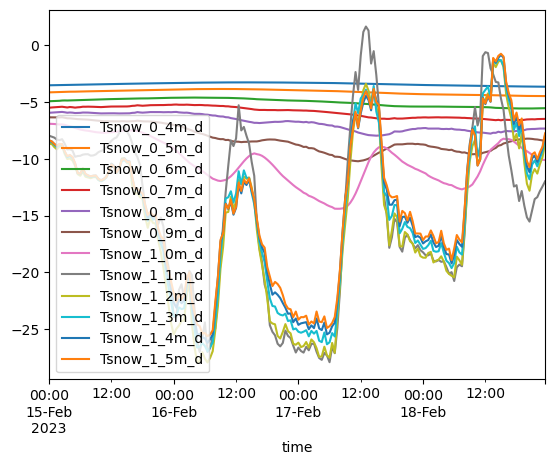

In [5]:
tsnow_data.loc['20230215': '20230218'].plot()

In the Module 4 labs, I will also use the plotting library Altair. I find Altair often makes it simpler to create more complex visualizations. 
The equivalent plot, made in Altair, is shown below.

In [6]:
!pip install altair

In [7]:
import altair as alt

In [8]:
alt.Chart(
    tsnow_data.loc['20230215': '20230218'].reset_index() # we have to reset the index b/c altair cannot work with an index, it needs `time` as a column
).mark_line().transform_fold(
    tsnow_vars,
    as_ = ['thermistor', 'temperature']
).encode(
    alt.X('time:T'),
    alt.Y('temperature:Q'),
    alt.Color('thermistor:O').sort(tsnow_vars),
    tooltip = 'thermistor:O' # try hovering our mouse over lines in the plot
).properties(width=400)

alt.Chart(...)

In later plots, you will see how altair often makes things easier than matplotlib.

The plot above is interesting, but we are interested in looking at the soil temperature profiles as a _vertical profile_. To do that, we will have to manipulate the data a bit.

# Extracting snow temperature data for vertical profiles

## Steps to manipulate dataset

We create a dataset that conveniently re-organizes the snowpack temperature measurements for visualization.

The snowpack temperature sensors were at fixed locations above the ground. The snow, which varies in height above ground level (AGL), buries different sensors at different times. 
To remove data points, we use the snowdepth measurements (in time) to calculate the depth of each temperature sensor (at a given height AGL) relative to the snow surface height (AGL). 
We then remove any data points from temperature sensors (and timestamps) above the snow surface.

In [9]:
# Transform the NetCDF dataset to be a "tidy" dataset of snow depths
snow_temp_dataset = sos_dataset[
    tsnow_vars + snow_depth_vars
].to_dataframe().reset_index().set_index(['time', 'SnowDepth_d']).melt(ignore_index=False)

# Calculate the depth of the snow sensor (relative to the snow surface)
# using the snow depth measurements and the known above-ground height
# of the snow sensors, which is built into the variable name
snow_temp_dataset['height_agl'] = snow_temp_dataset['variable'].str[6:9].str.replace('_', '.').astype(float)
snow_temp_dataset = snow_temp_dataset.reset_index().set_index('time')
snow_temp_dataset['depth'] = snow_temp_dataset['height_agl'] - snow_temp_dataset['SnowDepth_d']

In [10]:
# remove measurements NOT in the snowpack
snow_temp_dataset = snow_temp_dataset.query("depth < 0")
snow_temp_dataset

,SnowDepth_d,variable,value,height_agl,depth
time,,,,,
2022-11-28 01:00:00,0.423657,Tsnow_0_4m_d,-9.056437,0.4,-0.023657
2022-11-28 01:30:00,0.461395,Tsnow_0_4m_d,-10.109233,0.4,-0.061395
2022-11-28 02:00:00,0.499132,Tsnow_0_4m_d,-9.103524,0.4,-0.099132
2022-11-28 02:30:00,0.536870,Tsnow_0_4m_d,-10.318118,0.4,-0.136870
2022-11-28 03:00:00,0.574608,Tsnow_0_4m_d,-11.310650,0.4,-0.174608
...,...,...,...,...,...
2023-04-09 11:00:00,1.509988,Tsnow_1_5m_d,-2.090520,1.5,-0.009988
2023-04-09 11:30:00,1.506667,Tsnow_1_5m_d,-2.059685,1.5,-0.006667
2023-04-09 12:00:00,1.503345,Tsnow_1_5m_d,-2.046416,1.5,-0.003345


In [11]:
# Add surface temperature data (depth=0)
surface_temps_dataset = sos_dataset['Tsurf_d'].to_dataframe()
surface_temps_dataset = surface_temps_dataset.rename(columns={'Tsurf_d': 'value'})
surface_temps_dataset['depth'] = 0
surface_temps_dataset

,value,depth
time,,
2022-11-01 00:00:00,NaN,0
2022-11-01 00:30:00,NaN,0
2022-11-01 01:00:00,NaN,0
2022-11-01 01:30:00,NaN,0
2022-11-01 02:00:00,NaN,0
...,...,...
2023-06-19 15:30:00,23.838074,0
2023-06-19 16:00:00,22.595795,0
2023-06-19 16:30:00,21.681244,0


In [12]:
snow_temp_dataset = pd.concat([snow_temp_dataset, surface_temps_dataset])

## Plotting snow temperature profiles.

For these plots, I think the altair plotting library is easiest.

In [13]:
src = snow_temp_dataset.sort_index().loc['20230204': '20230204'].reset_index()

alt.Chart(
    src.assign(hour = src.time.dt.hour)[src.time.dt.minute == 0][src.time.dt.hour % 3 == 2]
).mark_line(point=True).encode(
    alt.X('value:Q').title('T (˚C)'),
    alt.Y('depth:Q'),
    alt.Color('hour:O').scale(scheme='rainbow'),
    alt.Facet('date(time):O', columns=1),
    order='depth'
).properties(width=200, height = 200)

/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_73180/975513592.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  src.assign(hour = src.time.dt.hour)[src.time.dt.minute == 0][src.time.dt.hour % 3 == 2]


alt.Chart(...)

In [14]:
src = snow_temp_dataset.sort_index().loc['20230314': '20230314'].reset_index()
alt.Chart(
    src.assign(hour = src.time.dt.hour)[src.time.dt.minute == 0][src.time.dt.hour % 4 == 2]
).mark_line(point=True).encode(
    alt.X('value:Q').title('T (˚C)'),
    alt.Y('depth:Q').title('depth (m)'),
    alt.Color('hour:O').scale(scheme='rainbow'),
    alt.Facet('date(time):O', columns=3),
    order='depth'
).properties(width=200, height = 200, title = '20230312')

/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_73180/598782676.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  src.assign(hour = src.time.dt.hour)[src.time.dt.minute == 0][src.time.dt.hour % 4 == 2]


alt.Chart(...)

In [12]:
src = snow_temp_dataset.sort_index().loc['20230312': '20230314'].reset_index()
alt.Chart(
    src.assign(hour = src.time.dt.hour)[src.time.dt.minute == 0][src.time.dt.hour % 3 == 2]
).mark_line(point=True).encode(
    alt.X('value:Q').title('T (˚C)'),
    alt.Y('depth:Q').title('depth (m)'),
    alt.Color('hour:O').scale(scheme='rainbow'),
    alt.Facet('date(time):O', columns=3),
    order='depth'
).properties(width=200, height = 200)

/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_75741/3393511937.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  src.assign(hour = src.time.dt.hour)[src.time.dt.minute == 0][src.time.dt.hour % 3 == 2]


alt.Chart(...)

In [28]:
src = snow_temp_dataset.sort_index().loc['20230407': '20230412'].reset_index()
alt.Chart(
    src.assign(hour = src.time.dt.hour)[src.time.dt.minute == 0][src.time.dt.hour % 3 == 2]
).mark_line(point=True).encode(
    alt.X('value:Q').title('T (˚C)'),
    alt.Y('depth:Q').title('depth (m)'),
    alt.Color('hour:O').scale(scheme='rainbow'),
    alt.Facet('date(time):O', columns=3).title(None).header(format='April %d'),
    order='depth'
).properties(width=150, height = 150, 
            #  title='Vertical Temperature Profiles in Snowpack'
             title=alt.TitleParams(text='Vertical Temperature Profiles in Snowpack', anchor='middle')
            )

/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_73180/2499543566.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  src.assign(hour = src.time.dt.hour)[src.time.dt.minute == 0][src.time.dt.hour % 3 == 2]


alt.Chart(...)